# Metric validation on simple synthetics data

One popular procedure for assessing seismogram denoising is to compute average power spectra for raw and denoised spectrograms.

When validating ML denoising results one can try to compare these spectra for target and model output to see how much they differ. Unfortunately this method can not see some undesirable modifications in models output

In this notebook we study some types of such modifications and compute a metrics that is more sensitive to them.

Metric compuation procedure is described in [Metric for evaluating difference between seismograms](./Metrics_study_intro.ipynb)


## Imports and Helper Function

First, define a helper function which draws seismograms, calculates metrics and draws average power spectra

In [1]:
import sys
sys.path.append('..')

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex 
from utils import get_cv, get_windowed_spectrogram_dists

In [2]:
def spectrum_plot_with_metrics(arrs, frame, rate, max_freq=None, names=None,
                  figsize=None, save_to=None, **kwargs):

    if isinstance(arrs, np.ndarray) and arrs.ndim == 2:
        arrs = (arrs,)

    if isinstance(names, str):
        names = (names,)
        
    origin = arrs[0]
    n_use_traces = frame[0].stop - frame[0].start

    _, ax = plt.subplots(2, len(arrs), figsize=figsize, squeeze=False)
    for i, arr in enumerate(arrs):
        ax[0, i].imshow(arr.T, **kwargs)
        rect = patches.Rectangle((frame[0].start, frame[1].start),
                                 frame[0].stop - frame[0].start,
                                 frame[1].stop - frame[1].start,
                                 edgecolor='r', facecolor='none', lw=2)
        ax[0, i].add_patch(rect)
        
        dist_m = get_windowed_spectrogram_dists(arr[0:n_use_traces], origin[0:n_use_traces])
        dist = np.mean(dist_m)
        
        ax[0, i].set_title('Seismogram {}. metric={}'.format(names[i] if names is not None else '', dist))
        ax[0, i].set_aspect('auto')
        spec = abs(np.fft.rfft(arr[frame], axis=1))**2
        freqs = np.fft.rfftfreq(len(arr[frame][0]), d=rate)
        if max_freq is None:
            max_freq = np.inf

        mask = freqs <= max_freq
        ax[1, i].plot(freqs[mask], np.mean(spec, axis=0)[mask], lw=2)
        ax[1, i].set_xlabel('Hz')
        ax[1, i].set_title('Spectrum plot {}'.format(names[i] if names is not None else ''))
        ax[1, i].set_aspect('auto')

## Dataset Loading

Load test data with sythesized spectrogram for very simple geology and compute some parameters

In [3]:
base_path = '/datasets/synthetic_4_metrics_study/'
field_index = FieldIndex(name='ideal', path=base_path+'SurfWave_G03_Reflection.sgy', extra_headers=['offset'])

field_index._idf['offset'] = field_index._idf['offset'].abs()

batch = (Dataset(field_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components=('ideal', ))
         .sort_traces(src='ideal', dst='ideal', sort_by='offset'))

ideal = batch.ideal[0]

# fix bad correction attempt
ideal = np.copy(ideal)
ideal[:, :400] = ideal[:, :400] * np.nanmean(ideal[:, 400]/ideal[:, 399], )

cv = get_cv([ideal])

## Compute metrics for noisy seismograms

### Traces shuffling

To begin with, we make noisy seismogram by shffling traces in a rectangle window. 

Metrics value indicates that 2 seismorgams differ, but if we check mean power spectra in the same window, we see that they are identical

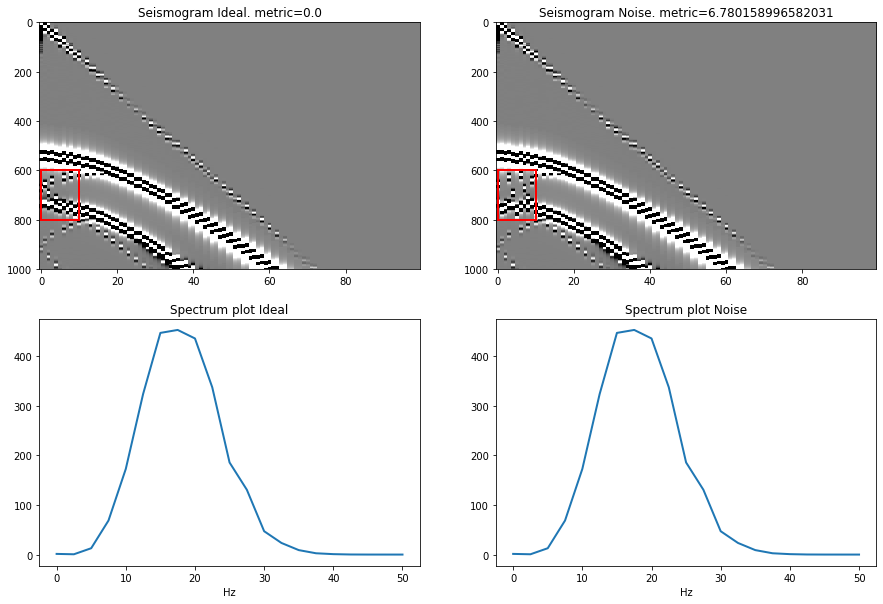

In [4]:
tmax = 10
sl2 = slice(600, 800)
sl_len = 200

i_mod = np.copy(ideal)
i_mod[0:tmax, sl2] = i_mod[np.random.permutation(tmax), sl2]

spectrum_plot_with_metrics([ideal, i_mod], frame=(slice(0, tmax), sl2), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['Ideal', 'Noise'])

### Adding normal noise

We can add normal noise to some traces and make other traces compensate the difference in power spectra, 
so that tha still are nearly same. Actually, all the difference is due to computational error

Metric is sensitive to the difference


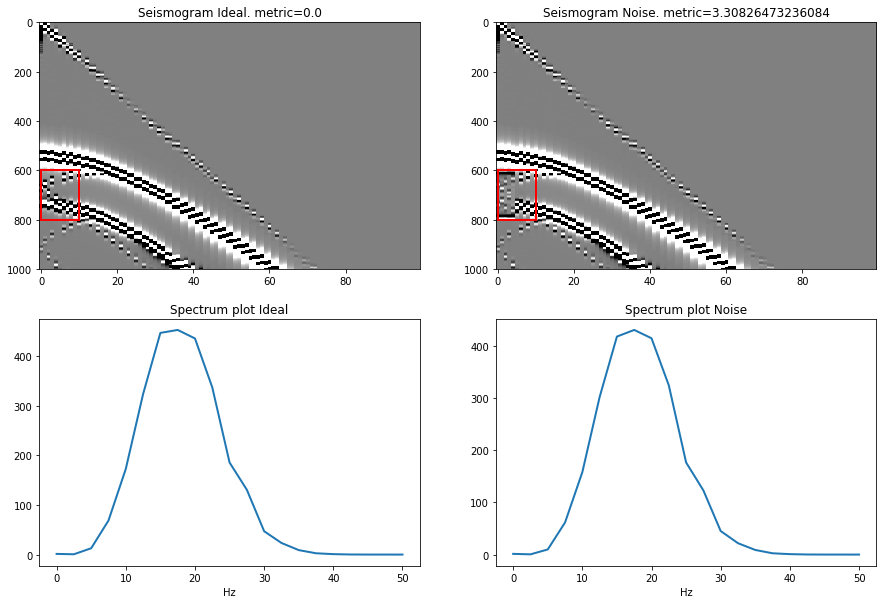

In [5]:
i_mod = np.copy(ideal)
for i in range(5):
    j = 10 - i
    f1 = abs(np.fft.rfft(ideal[j, sl2]))**2
    f2 = abs(np.fft.rfft(ideal[i, sl2]))**2
    i_mod[j, sl2] += np.random.randn(*i_mod[j, sl2].shape) * 1e-6
    f11 = abs(np.fft.rfft(i_mod[j, sl2]))**2
    f21_sq = np.sqrt(f1 - f11 + f2)
    i_mod[i, sl2] = np.fft.ifft(f21_sq, sl_len)

spectrum_plot_with_metrics([ideal, i_mod], frame=(slice(0, tmax), sl2), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['Ideal', 'Noise'])

### Zeroing Traces and Replacing Traces with Pure Sine

We can even make some traces zero or pure sine wave and make others compensate for that. 

Power spectra don't show any significant difference here, but metrics does

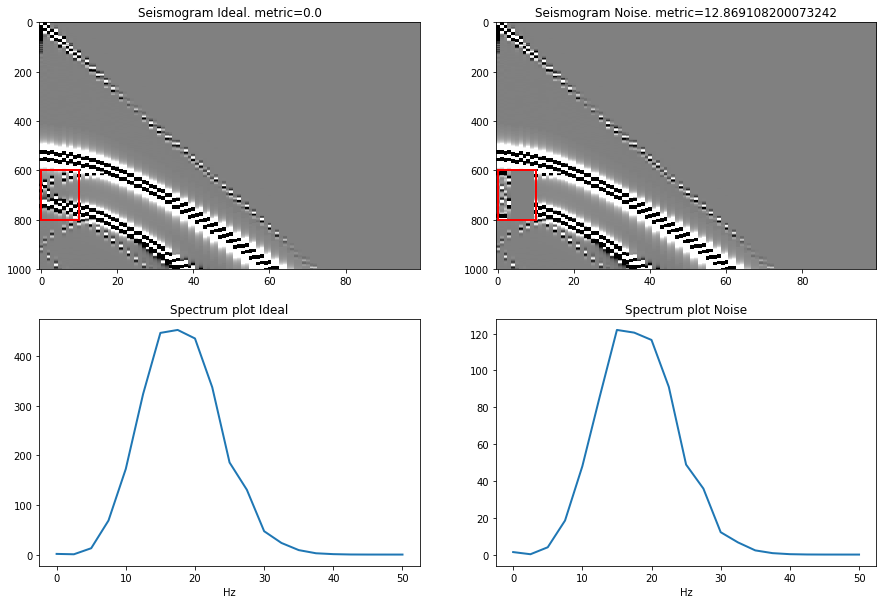

In [6]:
i_mod = np.copy(ideal)
for i in (0,1,2):
    j = i + 4
    k = i + 7
    f0 = abs(np.fft.rfft(ideal[j, sl2]))**2
    f1 = abs(np.fft.rfft(ideal[k, sl2]))**2
    f2 = abs(np.fft.rfft(ideal[i, sl2]))**2
    i_mod[j, sl2] = np.zeros(*i_mod[j, sl2].shape)
    f11 = abs(np.fft.rfft(i_mod[j, sl2]))**2
    i_mod[k, sl2] = np.zeros(*i_mod[j, sl2].shape)
    f01 = abs(np.fft.rfft(i_mod[k, sl2]))**2
    f21_sq = np.sqrt(f0 - f01 + f1 - f11 + f2)
    i_mod[i, sl2] = np.fft.ifft(f21_sq, sl_len)

spectrum_plot_with_metrics([ideal, i_mod], frame=(slice(0, tmax), sl2), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['Ideal', 'Noise'])

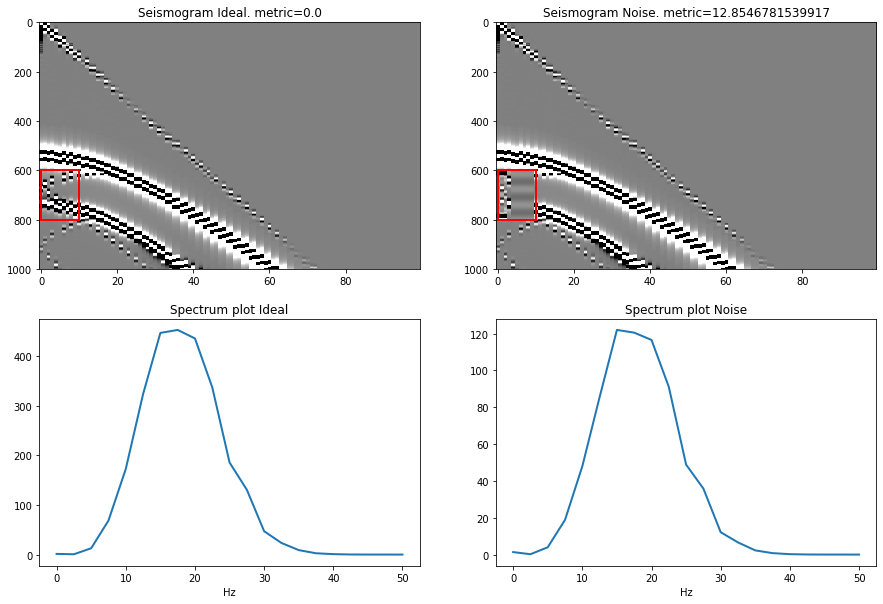

In [7]:
i_mod = np.copy(ideal)
for i in (0,1,2):
    j = i + 4
    k = i + 7
    f0 = abs(np.fft.rfft(ideal[j, sl2]))**2
    f1 = abs(np.fft.rfft(ideal[k, sl2]))**2
    f2 = abs(np.fft.rfft(ideal[i, sl2]))**2
    i_mod[j, sl2] = np.sin(0.1*np.arange(*i_mod[j, sl2].shape)) *0.01
    f11 = abs(np.fft.rfft(i_mod[j, sl2]))**2
    i_mod[k, sl2] = np.sin(0.1*np.arange(*i_mod[j, sl2].shape)) *0.01
    f01 = abs(np.fft.rfft(i_mod[k, sl2]))**2
    f21_sq = np.sqrt(f0 - f01 + f1 - f11 + f2)
    i_mod[i, sl2] = np.fft.ifft(f21_sq, sl_len)

spectrum_plot_with_metrics([ideal, i_mod], frame=(slice(0, tmax), sl2), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['Ideal', 'Noise'])